API data loaded: 55 rows
  Country  Year         Value Country_Name
0  poland  2023  8.124511e+11       Poland
1  poland  2022  6.956075e+11       Poland
2  poland  2021  6.891702e+11       Poland
3  poland  2020  6.059142e+11       Poland
4  poland  2019  6.026838e+11       Poland


/tmp/ipython-input-1248113798.py:52: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]



Wikipedia data loaded:
          Country  GDP_per_capita_USD
63         poland             28485.0
86         turkey             18198.0
108        brazil              9964.0
135  south africa              6397.0
167         india              2878.0

Данные объединены:
        Country         Value  GDP_per_capita_USD
0        poland  8.124511e+11             28485.0
1         india  3.638489e+12              2878.0
2        brazil  2.191132e+12              9964.0
3  south africa  3.806993e+11              6397.0

Описательная статистика:
              Value  GDP_per_capita_USD
count  4.000000e+00            4.000000
mean   1.755693e+12        11931.000000
std    1.473640e+12        11408.855771
min    3.806993e+11         2878.000000
25%    7.045132e+11         5517.250000
50%    1.501791e+12         8180.500000
75%    2.552971e+12        14594.250000
max    3.638489e+12        28485.000000

Корреляция между Total GDP и GDP per Capita:
                       Value  GDP_per_capita_U

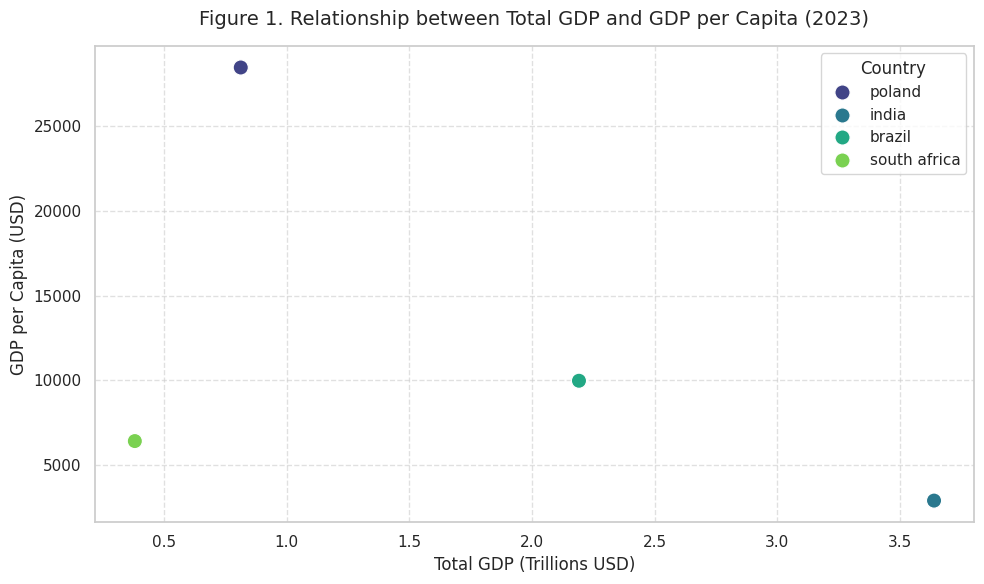

/tmp/ipython-input-1248113798.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged, x="Country", y="GDP_per_capita_USD", palette="viridis")


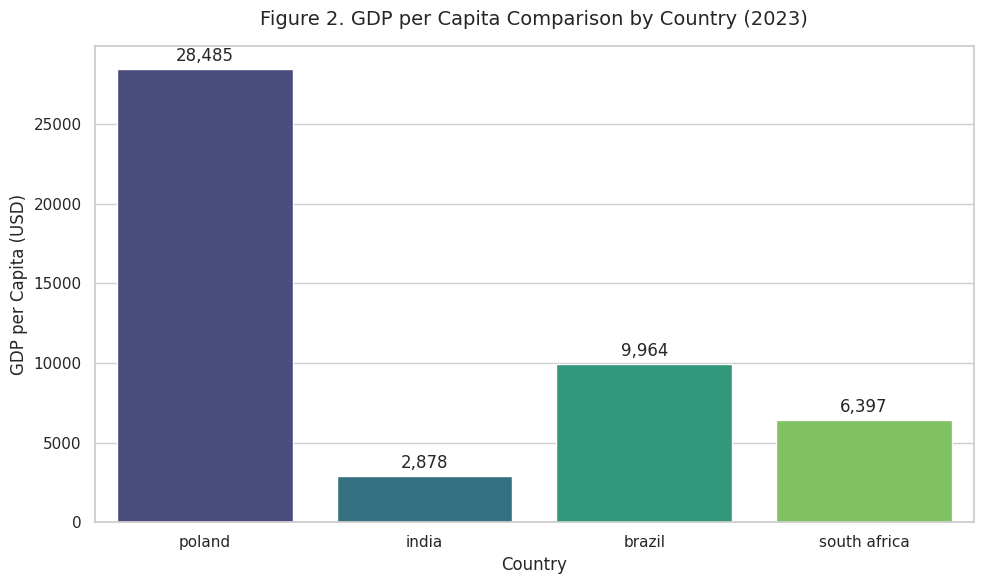

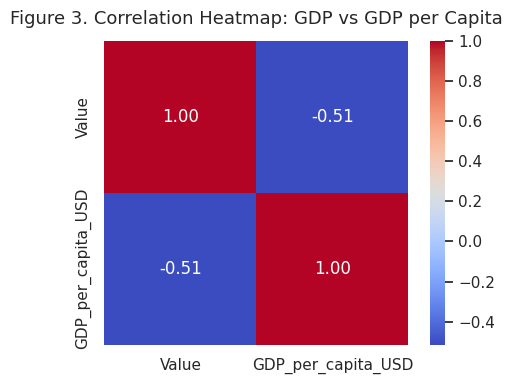

In [21]:
# --- Libraries ---
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

sns.set(style="whitegrid")

# --- 1. API: GDP (World Bank) ---
def get_worldbank_data(country_code, indicator="NY.GDP.MKTP.CD", start=2013, end=2023):
    url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}?format=json&date={start}:{end}&per_page=200"
    r = requests.get(url)
    data = r.json()
    if not isinstance(data, list) or len(data) < 2:
        return pd.DataFrame()
    records = data[1]
    df = pd.DataFrame([{
        "Country": rec["country"]["value"].lower(),
        "Year": int(rec["date"]),
        "Value": rec["value"]
    } for rec in records if rec["value"] is not None])
    return df

countries = {
    "POL": "Poland",
    "TUR": "Turkey",
    "IND": "India",
    "BRA": "Brazil",
    "ZAF": "South Africa"
}

dfs = []
for code, name in countries.items():
    df = get_worldbank_data(code)
    df["Country_Name"] = name
    dfs.append(df)

api_data = pd.concat(dfs, ignore_index=True)
print(f"API data loaded: {len(api_data)} rows")
print(api_data.head())

# --- 2. Web scraping: GDP per capita (Wikipedia) ---
url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita"
headers = {"User-Agent": "Mozilla/5.0"}

r = requests.get(url, headers=headers)
soup = BeautifulSoup(r.text, "html.parser")

table = soup.find("table", {"class": "wikitable"})
df = pd.read_html(str(table))[0]

df.columns = [str(c).strip() for c in df.columns]
df = df.rename(columns={df.columns[0]: "Country", df.columns[1]: "GDP_per_capita_USD"})

df["GDP_per_capita_USD"] = (
    df["GDP_per_capita_USD"]
    .astype(str)
    .str.replace(",", "")
    .str.extract(r"(\d+\.?\d*)")[0]
    .astype(float)
)

df["Country"] = df["Country"].astype(str).str.lower().str.strip()
df["Country"] = df["Country"].replace({"türkiye": "turkey", "brasil": "brazil"})

selected = ["brazil", "india", "poland", "south africa", "turkey"]
df = df[df["Country"].isin(selected)]

print("\nWikipedia data loaded:")
print(df[["Country", "GDP_per_capita_USD"]])

# --- 3. Merge API + Wiki ---
latest_year = api_data["Year"].max()
api_latest = api_data[api_data["Year"] == latest_year].copy()

api_latest["Country"] = api_latest["Country"].replace({"türkiye": "turkey"}).str.lower().str.strip()

merged = pd.merge(api_latest, df, on="Country", how="inner")[["Country", "Value", "GDP_per_capita_USD"]]
print("\nДанные объединены:")
print(merged)

# --- 4. Analysis ---
print("\nОписательная статистика:")
print(merged.describe())

print("\nКорреляция между Total GDP и GDP per Capita:")
print(merged[["Value", "GDP_per_capita_USD"]].corr())

# --- 5. Visualizations ---

# Figure 1 — Scatter
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged, x="Value", y="GDP_per_capita_USD", hue="Country", s=120, palette="viridis")
plt.title("Figure 1. Relationship between Total GDP and GDP per Capita (2023)", fontsize=14, pad=15)
plt.xlabel("Total GDP (Trillions USD)")
plt.ylabel("GDP per Capita (USD)")
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e12:.1f}"))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Country")
plt.tight_layout()
plt.show()

# Figure 2 — Barplot
plt.figure(figsize=(10,6))
sns.barplot(data=merged, x="Country", y="GDP_per_capita_USD", palette="viridis")
plt.title("Figure 2. GDP per Capita Comparison by Country (2023)", fontsize=14, pad=15)
plt.xlabel("Country")
plt.ylabel("GDP per Capita (USD)")
for i, row in enumerate(merged.itertuples()):
    plt.text(i, row.GDP_per_capita_USD + 500, f"{int(row.GDP_per_capita_USD):,}", ha="center")
plt.tight_layout()
plt.show()

# Figure 3 — Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(merged[["Value", "GDP_per_capita_USD"]].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Figure 3. Correlation Heatmap: GDP vs GDP per Capita", fontsize=13, pad=12)
plt.tight_layout()
plt.show()


